# 1. Reading and Exploring Data


## Import Libraries


We are importing different libraries for the data processing and analysis


In [9]:
import pandas as pd
import geopandas as gpd
import datetime
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt

## Reading and Exploring Data


The dataset was provided with the task as a csv file with documentation describing data in different columns. It contains data as output from LiDAR-based Multiple Object Tracking system. In the following steps we will explore the dataset.


Reading dataset and getting general info about data in different columns, showing the head part of the dataframe:


In [10]:
data = pd.read_csv('data/full_intersection_15.csv', sep=";")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563480 entries, 0 to 2563479
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   object_id        int64  
 1   timestamp        int64  
 2   heading          float64
 3   height           float64
 4   width            float64
 5   length           float64
 6   v                float64
 7   tracking_status  object 
 8   object_type      object 
 9   lon              float64
 10  lat              float64
dtypes: float64(7), int64(2), object(2)
memory usage: 215.1+ MB


,object_id,timestamp,heading,height,width,length,v,tracking_status,object_type,lon,lat
0,152997118,1712062811083,132.072,0.735,1.942,4.387,0.03,TRACKING,CAR,13.064405,47.810136
1,152997118,1712062811183,132.286,0.731,1.861,4.320,0.04,TRACKING,CAR,13.064405,47.810136
2,152997118,1712062811283,132.229,0.739,1.955,4.395,0.03,TRACKING,CAR,13.064405,47.810136
3,152997118,1712062811386,131.980,0.729,1.942,4.367,0.04,TRACKING,CAR,13.064405,47.810135
4,152997118,1712062811485,132.020,0.737,1.875,4.328,0.02,TRACKING,CAR,13.064405,47.810136


The data has 2563480 entires (trajectory points) with different characteristics such as object_id, timestamp (in ms), longitude and latitude, heading, height, width, length of the vehicle, velocity, tracking status and object_type


## Exploring the data


### Area of Research


The data was collected in **Salzburg, Austria** at the intersection of Sterneckstraße, Linzer Bunderrtraße, Ignaz-Härtl-Straße and Fürbergstraße


In [11]:
buffer = gpd.GeoSeries([Point(13.064405, 47.810136)], crs="EPSG:4326").to_crs(epsg=32633).buffer(200)
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs =32633 )
buffer_gdf.explore(tiles='Esri.WorldImagery')

### Time


In [12]:
minData = datetime.datetime.fromtimestamp(int(min(data['timestamp'])/1000))
maxData = datetime.datetime.fromtimestamp(int(max(data['timestamp'])/1000))
print("It was collected from: %s, To: %s" % (minData, maxData))

It was collected from: 2024-04-02 16:00:00, To: 2024-04-02 16:59:59


### Total observations


In [13]:
print("Total observations in a raw dataset: %i" % (data.size))
print("Total unique objects: %i" % (data['object_id'].nunique()))

Total observations in a raw dataset: 28198280
Total unique objects: 34580


### Tracking Status


On of the main points characteristics is tracking status. Let's see the structure for points based on this column:


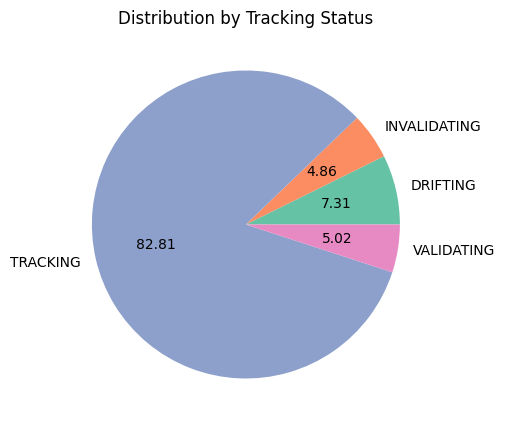

In [14]:
data_by_status = data.groupby("tracking_status").size()
plt.figure(figsize=(5,5))
data_by_status.plot.pie(autopct="%.2f", colors=sns.color_palette("Set2"))
plt.title('Distribution by Tracking Status')
plt.show()

More than 82% of all points have "TRACKING" status which shows "stable tracking". Other categories are "INVALIDATING", "DRIFTING" and "VALIDATING" are not considered as 'stable tracking' and we will filter this data and won't consider in the following analysis


### Filterting Objects Based on Tracking Status and Calculating New Number of Observations


In [15]:
data_cleaned = data[data['tracking_status']=='TRACKING']

In [16]:
print("Observations Total (cleaned data): %i. Share of raw: %i percent" % (data_cleaned.size, (data_cleaned.size/data.size)*100))
print("Total unique objects (cleaned data): %i. Share of raw: %i percent" % (data_cleaned['object_id'].nunique(), (data_cleaned['object_id'].nunique()/data['object_id'].nunique())*100))

Observations Total (cleaned data): 23349700. Share of raw: 82 percent
Total unique objects (cleaned data): 11025. Share of raw: 31 percent


### Objects Types


The data was collected for different object types: cars, two-wheelers, and pedestrians. Let's explore the share of each object type in the data.


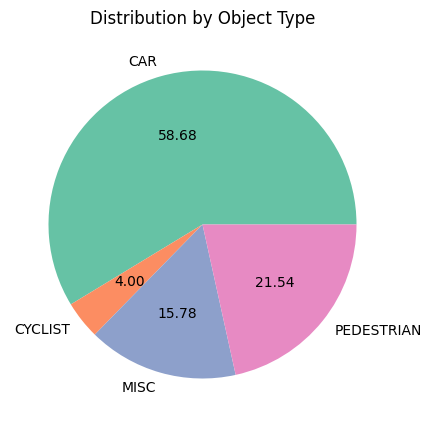

In [17]:
data_by_object = data_cleaned.groupby("object_type").size()

plt.figure(figsize=(5,5))
data_by_object.plot.pie(autopct="%.2f", colors=sns.color_palette("Set2"))

# Set title and show plot
plt.title('Distribution by Object Type')
plt.show()

More than 58% are cars, around 21% are pedestrians, and 4% are two-wheelers. Additionally, 15.78% are classified as "MISC," which means that the objects are not considered part of any of the three main classes. We will filter out these objects and, in the following analysis, consider only the three main types.


### Filterting Objects Based on Object Type and Calculating New Number of Observations


In [18]:
data_cleaned = data_cleaned[data_cleaned['object_type'] != 'MISC']

### Share of all data left after the first filters applied


In [19]:
print("Observations Total (cleaned data): %i. Share of raw: %i percent" % (data_cleaned.size, (data_cleaned.size/data.size)*100))
print("Total unique objects (cleaned data): %i. Share of raw: %i percent" % (data_cleaned['object_id'].nunique(), (data_cleaned['object_id'].nunique()/data['object_id'].nunique())*100))

Observations Total (cleaned data): 19664513. Share of raw: 69 percent
Total unique objects (cleaned data): 6500. Share of raw: 18 percent


After filtering out irrelevant data based on "Tracking Status" and "Object Type," we have prepared the data for further analysis. Approximately 70% of all points and only 18% of unique objects remain. This indicates that the filtered objects had significantly fewer points on average, supporting the idea that the filtered data was indeed irrelevant.


### Saving Final Result


In [21]:
#data_cleaned.to_csv('data/1_data_cleaned.csv')